# This notebook explains, visualizes, and analyses the ePodium dataset.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import ipywidgets
import wave # For analyzing .wav audio files

import local_paths

from functions import epodium
from functions import display_helper

<br>

## Loading EEG-data and metadata

   Make sure *local_paths.ePod_dataset* contains the path to the __dataset__ and *local_paths.ePod_metadata* contains the __metadata__ files.

* *children.txt* contains the age and sex, and risk of dyslexia due to at least 1 dyslexic parents.
* *cdi.txt* contains aditional information about the child's vocabulary with the Communicative Development Inventories questionnaire
* *parents.txt* contains info on dyslexia tests and diagnoses of the parents.
* *CODES_overview* contains the mapping of event condition and stimulus to an event number.

In [2]:
dataset_raw, dataset_filenames = epodium.load_dataset(local_paths.ePod_dataset, preload=False)

epodium_metadata_filenames = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]
epod_children, epod_cdi, epod_parents, epod_codes = \
    epodium.load_metadata(local_paths.ePod_metadata, epodium_metadata_filenames)

248 EEG files loaded


#### Participants Info

In [3]:
clean_b_dataframe = epod_children.loc[epod_children['Age_days_b'].str.isnumeric()]

print(f"The participants are between the age of {epod_children['Age_days_a'].min()} and\
 {int(clean_b_dataframe['Age_days_b'].max())} days.  ({round(epod_children['Age_months_a'].min(),1)} to\
 {float(clean_b_dataframe['Age_months_b'].max())} months)")

The participants are between the age of 487 and 756 days.  (16.2 to 25.2 months)


<br>

## ePodium Events

   The ePodium experiment is an *auditory oddball experiment*. Children listen to a sequence that contains __80% standard__ and __20% deviant__ syllables in order to elicit the *mismatch response*. 
    For measurement 34 electrodes are used, of which __32 channels__ and 2 mastoid references. The measurement frequency is __2048.0 Hz__. 
    Each test is around __30 minutes__, with sequences of around 7.5 minutes containing four different conditions:

+ Condition 1 __GiepMT__: standard "*giep*", deviant "*gip*": multiple pronounciations 
+ Condition 2 __GiepST__: standard "*giep*", deviant "*gip*": single pronounciation 
+ Condition 3 __GopMT__: standard "*gop*", deviant "*goep*": multiple pronounciations 
+ Condition 4 __GopST__: standard "*gop*", deviant "*goep*": single pronounciation


#### Analyse audio file

In [14]:
def print_sound_duration(sounds):
    path_sound = os.path.join(local_paths.ePod_metadata, 'sounds', sounds)
    with wave.open(path_sound) as mywav:
        duration_seconds = mywav.getnframes() / mywav.getframerate()
        print(f"Length of the WAV file: {duration_seconds:.3f} s")
        
epod_sounds = sorted(os.listdir(os.path.join(local_paths.ePod_metadata, 'sounds')))
ipywidgets.interact(print_sound_duration, sounds=epod_sounds);

interactive(children=(Dropdown(description='sounds', options=('giep_s02.wav', 'giep_s03.wav', 'giep_s05.wav', …

### Load events
Events are stored into .txt file for faster initialization


In [5]:
# Store events in local path
n_events_stored = len(glob.glob(os.path.join(local_paths.ePod_events, '*.txt')))
if n_events_stored != len(dataset_raw):
    epodium.save_events(local_paths.ePod_events, dataset_raw, dataset_filenames)

# Load events
events = epodium.load_events(local_paths.ePod_events, dataset_filenames)

# Set multiple pronounciations as same event id to reduce the unique events from 78 to 12.
events_12 = epodium.group_events_12(events)

248 Event Marker files loaded


#### Choose which participant to analyse

In [28]:
def f(experiments):
    return experiments

participant_widget = ipywidgets.interactive(f, experiments=sorted(dataset_filenames))
display(participant_widget)

interactive(children=(Dropdown(description='experiments', options=('101a', '101b', '102a', '102b', '103a', '10…

#### Show part of the EEG signal
When a new experiment is chosen, this cell needs to be run again.

Using matplotlib as 2D backend.
Opening raw-browser...


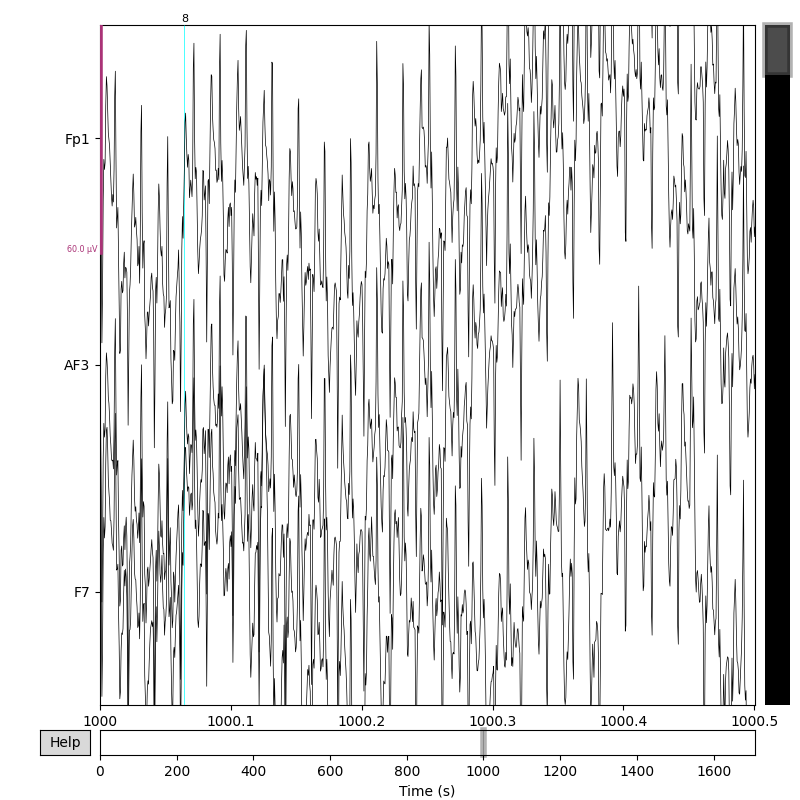

In [7]:
# Makes the plot interactive, comment out if not working.
%matplotlib widget 

participant_raw = dataset_raw[dataset_filenames.index(participant_widget.result)]
participant_events = events_12[dataset_filenames.index(participant_widget.result)]

fig = mne.viz.plot_raw(participant_raw, participant_events, n_channels = 3, 
                       scalings = 30e-6, duration = 0.5, start = 1000)

#### Plot events across time

The events are grouped into __12 event types__, 3 for each condition. 

Ideally, each condition has __120 deviants__ (D) and __360 standards__ (S).

The test also contains __first standards__ (FS) to make the child accustomed to the standard. First standards are discarded when calculating the mismatch response. 

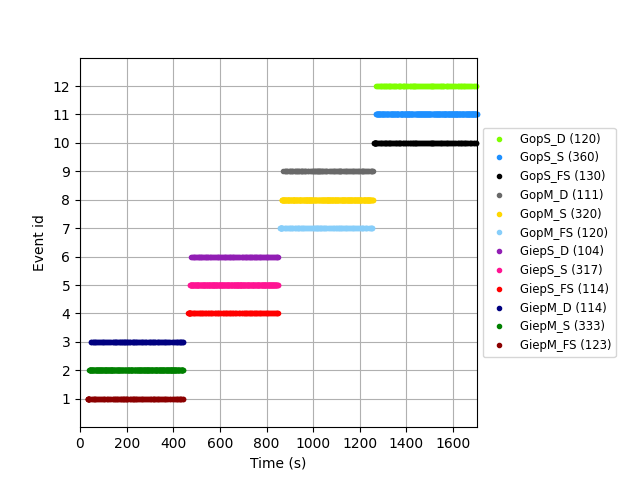

In [8]:
fig = mne.viz.plot_events(participant_events, event_id = epodium.event_dictionary, 
                          color = display_helper.color_dictionary, sfreq = 2048)

<br>


## Analysing event related potentials (ERPs)

   The voltage change in the brain as a response to an event is called the *event-related potential* (ERP)
    The response difference between a standard and deviant ERP is called the *mismatch response* (MMR).
    The mismatch response can be analysed to predict differences between participants.


#### Choose which processed data to use

In [9]:
processing_widget = ipywidgets.RadioButtons(options=['autoreject', 'ransac'], 
                                            description='processing:',
                                            value = "autoreject")
display(processing_widget)

RadioButtons(description='processing:', options=('autoreject', 'ransac'), value='autoreject')

#### Choose participant

In [43]:
display(participant_widget)

interactive(children=(Dropdown(description='experiments', options=('101a', '101b', '102a', '102b', '103a', '10…

#### Load participant data
Rerun the following code after changing processing method or participant to load the correct epochs:

In [56]:
path_processed = os.path.join(local_paths.processed, "ePod_" + processing_widget.value)
path_npy = os.path.join(path_processed, "epochs",  participant_widget.result + ".npy")
path_events = os.path.join(path_processed, "events", participant_widget.result + ".txt")

epochs = epodium.load_processed_file(path_npy, path_events)

2440 different trials loaded 
Each trial contains 2049 timesteps in 32 channels.


#### Widget for plotting standard, deviant, and mismatch ERPs

In [60]:
condition = ipywidgets.RadioButtons(options=epodium.conditions, 
                                    description='Condition:',
                                    value = "GiepM")
event_type = ipywidgets.RadioButtons(options=["standard", "deviant", "MMN"], 
                                     description='Event type:', 
                                     value = "standard")

def plot_ERP_widget(con, ev):
    epodium.plot_ERP(epochs, con, ev)
ui = ipywidgets.HBox([condition, event_type])
out = ipywidgets.interactive_output(plot_ERP_widget, {'con': condition, 'ev': event_type})
display(ui, out)

Output()